# MadGraph Energy Spectrum Conversion

## Description

This notebook

1. Copies and renames all `.lhe` files to their immediate parent directory 

        Home\Temp\test.lhe    -----this-code--->    Home\Temp\test.lhe
                                                             |Temp.lhe

1. Converts `.lhe` files to `.csv` files in their respective locations

        Home\Temp\test.lhe    -----this-code--->    Home\Temp\test.lhe
                                                             |Temp.csv

2. Plots a histogram of those energies from the .csv

3. Generates a probability density function from the histogram of outgoing energies

## Why not use BeautifulSoup?

BeautifulSoup is a package that is built for traversing `.html` files. This makes it extremely easy to locate the relevant lines in the `.lhe` files that correspond to the particle events we care about. **However**, Beautifulsoup interprets all the information between the `<event> ... </event>` tags as a **single** line. This makes extracting information about a particle incredibly difficult. I have since given up on BeautifulSoup and implemented my own logic to solve this problem.

## Before Running this notebook

There are a few things to double check on your machine before running this notebook.

1. This notebook does *not* provide a way to unzip the files produced from MadGraph. You will have to extract the contents manually.

    (Detailed Explanation) For each run, Madgraph produces a folder with the following contents:

        \Path-to-MadGraph\Process-You-Care-About\
        |
        |--- run_##\
        |---|--- run##_run-tag-name_banner.txt
        |   |--- unweighted_events.lhe.gz
        |
The `unweightedevents.lhe.gz` file is some sort of zipped file. Extract the contents inside of its parent folder. After extracting, your `run_##` folder should look like:

        \Path-to-MadGraph\Process-You-Care-About\
        |
        |--- run_##\
        |---|--- run##_run-tag-name_banner.txt
        |   |--- unweighted_events.lhe.gz
        |   |--- unweighted_events.lhe
        
2. If your model has any particles not defined in the PDG, you will need to manually input their PDG codes into the `PID` dictionary. 

3. The conversion process assumes the following file directory structure:

        \Path-to-this-notebook\
        | 
        |--- Data\
        |
        |---|--- lhe\
        |---|---|--- date\
        |---|---|---|--- run_##\
        |---|---|---|---|--- run##_run-tag-name_banner.txt
        |---|---|---|---|--- unweighted_events.lhe.gz
        |---|---|---|---|--- unweighted_events.lhe
        |---|---|---|--- run_##\
        |---|---|---|---|--- run##_run-tag-name_banner.txt
        |---|---|---|---|--- unweighted_events.lhe.gz
        |---|---|---|---|--- unweighted_events.lhe
        |
        |---|--- csv\
        |---|---|--- date\
        |        
        
 `lhe` files will be sourced from the `lhe` branch and will be converted and exported into the `csv` branch in their respective folders.
 
4. `date` must be the direct parent directory of the lhe files you want to convert, not the grandparent or great-grandparent directory.

5. It is only necessary to unzip each `.lhe` file from the `.gz` within its own `run_##\` folder. You do not need to move the `.lhe` file anywhere.

## Imports

`PID` is a dictionary whose keys are the particle names and values are the particle ID's

`get_key(my_dict, val)` is a function whose input is a dictionary and value and that returns the key from `my_dict` corresponding to `val`

In [1]:
import numpy as np

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.integrate as integrate
import shutil


%matplotlib inline

def eventFilePath(fileName):
    return 'MadGraph_Events/lhe/' + fileName

def CSVFilePath(fileName):
    return 'MadGraph_Events/csv/' + fileName

PID = {
    'down':1,
    'Adown':-1,
    'up':2,
    'Aup':-2,
    'strange':3,
    'Astrange':-3,
    'charm':4,
    'Acharm':-4,
    'bottom':5,
    'Abottom':-5,
    'top':6,
    'Atop':-6,
    'bPrime':7,
    'AbPrime':-7,
    'tPrime':8,
    'AtPrime':-8,
    'eMinus':11,
    'AeMinus':-11,
    'nuE':12,
    'AnuE':-12,
    'muMinus':13,
    'AmuMinus':-13,
    'nuMu':14,
    'AnuMu':-14,
    'tauMinus':15,
    'AtauMinus':-15,
    'nuTau':16,
    'AnuTau':-16,
    'tauPrime':17,
    'AtauPrime':-17,
    'nuTauPrime':18,
    'AnuTauPrime':-18,
    'gluon':21,
    'photon':22,
    'Z':23,
    'W+':24,
    'higgs':25,
    'chi':100,
    'Achi':-100,
    'phi':101
}

def get_key(my_dict,val): 
    for key, value in my_dict.items(): 
         if val == value: 
            return key 
    return "Key doesn't exist"

def lheFileRename(inputDir,outputType = '.lhe'):
    filesVect = []
    for root, dirs, files in os.walk(inputDir):
        for f in files:
            if f.endswith('.lhe'):
                filesVect.append(f)
                path = os.path.join(root, f)
                pathSplit = path.split("\\")
                tempPath = ''
                for chunk in pathSplit[0:-1]:
                    tempPath = tempPath + chunk + "\\"
                newPath = tempPath+pathSplit[-2]+'.lhe'
                try:
                    shutil.copy(path,newPath)
                except shutil.SameFileError:
                    continue
                    
def findFiles(fullPath,filetype):
    filesVect = []
    for root, dirs, files in os.walk(fullPath):
        for f in files:
            if (f.endswith(filetype) and (f[:-4] != 'unweighted_events')):
                fullPath = os.path.join(root, f)
                filesVect.append(fullPath)
    return filesVect

print ('Complete')

Complete


## Accessing LHE Data

Here is what looks to be the original scheme to these files: [LHE File](https://arxiv.org/pdf/hep-ph/0109068.pdf)

```
<event>
# Particles, Event ID, Event Weight, Scale in GeV, QED Coupling, QCD Coupling

    PID, State, (Parent1, Parent2), (CF, ACF), (Px, Py, Pz, E, Mass), cTau, SpinProj
    
</event>
```
The key is:
 - `PID`: Particle ID assigned by the PDG. [Reference here](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf)
 
 - `State`:
 
 
      -1 = Initial
      +1 = Final
      -2 = Intermediate space-like propagator, $x$ and $Q^2$ preserved
      +2 = Intermediate resonance, mass preserved
      +3 = Intermediate resonance, for documentation only
      -9 = Incoming beam at $t = -\infty$
 
 - `Parent1/ Parent2`: Identify where the particle came from. These are NOT the PDG particle naming scheme. Rather, these assign the incomming particles as `1` and `2`.
         
 - `CF/ ACF`: (Anti)Color Flow, used to computate hadronization later down the computation chain.
 
 - `Px, Py, Pz, E, M`: Particle 4-vector and mass ($M$) all in GeV. Note that this mass is the reconstructed particle mass: $M^2(\vec{p}) = E^2 - \vec{p}\cdot \vec{p}$, NOT necessarily on shell.
 
 - `cTau`: Particle lifetime in mm. Distance from production to decay. Combined with momentum information, this is enough to determine vertex location
 
 - `SpinProj`: Cosine of the angle between the spin vector of the particle in question and 3-momentum of the decaying particle

# LHE to CSV conversion

### `.lhe` file Contents

This cell reads in a `.lhe` file and converts it to `.csv`. Note that information about the event ID is NOT saved.

The `.csv` has columns labeled as:

1. `RawNo`: This is the line number from the original `.lhe` file 
2. `PID`: Particle ID inaccordance with the PDG scheme
3. `State`:
4. `Parent1`:
5. `Parent2`:
6. `CF`:
7. `ACF`:
8. `Px: (*, Px, *, *)`
9. `Py: (*, *, Py, *)`
10. `Pz: (*, *, *, Pz)`
11. `E: (E, *, *, *)` 
12. `M`: Particle Mass
13. `cTau`:
14. `SpinProj`:

There is no need to modify by hand the `.lhe` file that `MADGRAPH` outputs, just read it in directly here.

### Automated File Traversal and Conversion

For this to work properly, the output folders must have already been created on your machine.

TO DO: 

1. Add path to lhe file name
1. add sanity check if the output files already exist in the output directory

In [3]:
# The date is the next-to-bottom level in the path
date = '9.19.22\\'

# The baseDir is specific to the user
baseDir   = 'C:\\Users\\asg00\\Desktop\\Machine Learning MT2\\Data\\'
inputDir  = baseDir + 'lhe\\' + date
outputDir = baseDir + 'csv\\' + date

lheFileRename(inputDir,outputType = '.lhe')


# Get the list of .lhe files in this directory
filesVect = findFiles(inputDir,'.lhe')
for file in filesVect:
    print (file)

yn = input('You are about to convert {0} files in \n    {1}\nProceed? [y,n]'.format(len(filesVect),inputDir))

if yn == 'y':
    print ('Conversion in progress...')
    for file in filesVect:
        lhefile = open(file)
        lhefileLines = lhefile.readlines()
        dataVect  = [] # This stores the actual data we will be using
        lineNoVect = [] # This indicates the line in the original lhe file
        lineNo = 0     # This counts the line number in the original lhe file
        eventNo = 0

        for i in range(0,len(lhefileLines)-1):
            lineNo +=1
            line = lhefileLines[i]
            nextLine = lhefileLines[i+1]
            if line.split() == []: # This skips over completely empty lines in the lhe file
                continue
                
            isCurrent6 = (len(line.split()) == 6)
            isNext13 = (len(nextLine.split())==13)
            
            
            # The information within the <event> tag always starts with a line of
            # six numbers followed by a line of 13 numbers. This will be our 
            # the way we identify the lines in the file that we care about.
            if isCurrent6 and isNext13:
                eventNo +=1
                numParticles = int(line.split()[0])
                for j in range(0,numParticles):
                    linej = lhefileLines[i+1+j]
                    lineArray = linej.split()
                    lineArray.insert(0,lineNo+j+1) # Insert lineNo at position 0 in the vector
                    lineArray.insert(1,eventNo)
                    dataVect.append(lineArray)
            
            columns = ['LineNo.',\
                   'EventNo.',\
                   'PID',\
                   'State',\
                   'Parent1', 'Parent2',\
                   'CF','ACF',\
                   'Px','Py','Pz','E','M',\
                   'cTau',\
                   'SpinProj']

        name = file[:-4]
        name = name.replace('lhe','csv')
        nameSplit = name.split('\\')
        nameSplit.pop(-2)
        name = "\\".join(nameSplit)
        df = pd.DataFrame(data = dataVect, columns = columns) #, dtype = float )
        csvFileName = name +'.csv'
        df.to_csv(csvFileName, index = False)
        print (csvFileName + ' converted')
else:
    print ('Conversion aborted')

            
print ('Complete') 

C:\Users\asg00\Desktop\Machine Learning MT2\Data\lhe\9.19.22\run_02\run_02.lhe
C:\Users\asg00\Desktop\Machine Learning MT2\Data\lhe\9.19.22\run_03\run_03.lhe
C:\Users\asg00\Desktop\Machine Learning MT2\Data\lhe\9.19.22\run_04\run_04.lhe
You are about to convert 3 files in 
    C:\Users\asg00\Desktop\Machine Learning MT2\Data\lhe\9.19.22\
Proceed? [y,n]y
Conversion in progress...
C:\Users\asg00\Desktop\Machine Learning MT2\Data\csv\9.19.22\run_02.csv converted
C:\Users\asg00\Desktop\Machine Learning MT2\Data\csv\9.19.22\run_03.csv converted
C:\Users\asg00\Desktop\Machine Learning MT2\Data\csv\9.19.22\run_04.csv converted
Complete


#### Old Individual Conversion Code

In [14]:
date = '21.3.23/'
name = date+input('Lhe File: ')
lhefile = open(eventFilePath(name))

dataVect  = [] # This stores the actual data we will be using
rawNoVect = [] # This indicates the line in the original lhe file
lineNo = 0     # This counts the line number in the original lhe file
eventNo = 0

for line in lhefile:
    lineNo +=1
    
    if line.split() == []: # This skips over completely empty lines in the lhe file
        continue
        
    ###########################
    # "How many particles are in this event"
    # The lines that contain the number of particles in each event is 6 entries long
    # The location in the string of the particle number in the event 1
    ###########################
    isLen6 = len(line.split()) == 6 # This picks out the relevant "particle number" lines
    isNumber = line[1].isnumeric()  # The "1th" entry in the string is the location of the particle number
    if isLen6 & isNumber:
        eventNo += 1
        
    ###########################
    # "Is the current line useful?"
    # isLen13 tells us if the line length is exactly 13 entries long
    #   13 is relevant because the useful lines are 13 entries long.
    # isParticle tells us if the line we are looking at contains a particle
    ###########################
    isLen13 = len(line.split()) == 13 # "13" corresponds to the number of entries in a useful line 
    isParticle = (line.split()[0]) in str(list((PID.values()))) # Convert to string to fix data-type error
    
    ###########################
    # "If yes, append it to our dataVect"
    ###########################
    if (isParticle & isLen13):
        lineArray = line.split()
        lineArray.insert(0,lineNo) # Insert lineNo at position 0 in the vector
        lineArray.insert(1,eventNo)
        dataVect.append(lineArray)

    columns = ['RawNo.',\
           'EventNo.',\
           'PID',\
           'State',\
           'Parent1', 'Parent2',\
           'CF','ACF',\
           'Px','Py','Pz','E','M',\
           'cTau',\
           'SpinProj']
    
    
df = pd.DataFrame(data = dataVect, columns = columns) #, dtype = float )
csvFileName = date + input('CSV File Name: ')
df.to_csv(CSVFilePath(csvFileName), index = True)

print ('Complete')    

Lhe File: run01.lhe
CSV File Name: run01.csv
Complete


# Analysis and Plots

#### Date and Run Parameters

### Initialization

In [16]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.integrate as integrate

%matplotlib inline

def eventFilePath(fileName):
    return 'MadGraph_Events/lhe/' + fileName

def CSVFilePath(fileName):
    return 'MadGraph_Events/csv/' + fileName

PID = {
    'down':1,
    'Adown':-1,
    'up':2,
    'Aup':-2,
    'strange':3,
    'Astrange':-3,
    'charm':4,
    'Acharm':-4,
    'bottom':5,
    'Abottom':-5,
    'top':6,
    'Atop':-6,
    'bPrime':7,
    'AbPrime':-7,
    'tPrime':8,
    'AtPrime':-8,
    'eMinus':11,
    'AeMinus':-11,
    'nuE':12,
    'AnuE':-12,
    'muMinus':13,
    'AmuMinus':-13,
    'nuMu':14,
    'AnuMu':-14,
    'tauMinus':15,
    'AtauMinus':-15,
    'nuTau':16,
    'AnuTau':-16,
    'tauPrime':17,
    'AtauPrime':-17,
    'nuTauPrime':18,
    'AnuTauPrime':-18,
    'gluon':21,
    'photon':22,
    'Z':23,
    'W+':24,
    'higgs':25,
    'chi':100,
    'Achi':-100,
    'phi':101,
    'A0': 36
}

def get_key(my_dict,val): 
    for key, value in my_dict.items(): 
         if val == value: 
            return key 

    return "Key doesn't exist"

print ('Complete')

Complete


### CSV Read-In

This cell reads in a csv file and creates a histogram of the data

The variable "nBins" determines the resolution of the PDF interpolation from the histogram. A higher number of bins yields a more accurate interpolation.

Bin size seems to be set by the energy resolution of the detector. For now we will arbitrarily choose 200 bins.

In [43]:
# fileIn = input('Input CSV File: ')
# df = pd.read_csv(CSVFilePath(fileIn),sep = ',')



# date = '3.17.20/2_2/'
# fileIn1 = date+'0122R10.csv'
# fileIn2 = date+'0222R100.csv'
# fileIn3 = date+'0322R1000.csv'
# fileIn4 = date+'0422R10000.csv'
# fileIn5 = date+'0522R10P.csv'
# fileIn6 = date+'0622R100P.csv'
# fileIn7 = date+'0722R1000P.csv'
# fileIn8 = date+'0822R10000P.csv'

# date = '3.17.20/2_3/'
# fileIn1 = date+'0123R10.csv'
# fileIn2 = date+'0223R100.csv'
# fileIn3 = date+'0323R1000.csv'
# fileIn4 = date+'0423R10000.csv'
# fileIn5 = date+'0523R10P.csv'
# fileIn6 = date+'0623R100P.csv'
# fileIn7 = date+'0723R1000P.csv'
# fileIn8 = date+'0823R10000P.csv'

# date = '3.19.20/'
# fileIn1 = date+'R09E10.1.csv'
# fileIn2 = date+'R10E10.01.csv'
# fileIn3 = date+'R11E10.001.csv'
# fileIn4 = date+'R12E10.0001.csv'

# date = '3.19.20/'
# fileIn1 = date+'25GeV.csv'
# fileIn2 = date+'100GeV.csv'
# fileIn3 = date+'1000GeV.csv'
# fileIn4 = date+'5000GeV.csv'

# date = '3.25.20/'
# fileIn1 = date+'2_3Ebeam10.1.csv'
# fileIn2 = date+'2_3Ebeam10.01.csv'
# fileIn3 = date+'2_3Ebeam10.001.csv'
# fileIn4 = date+'2_3Ebeam10.0001.csv'

# date = '11.17.20/'
# fileIn1 = date+'R14_E100_1.csv'
# fileIn2 = date+'R15_E500.csv'
# fileIn3 = date+'R16_E1000.csv'
# fileIn4 = date+'R17_E5000.csv'
# fileIn5 = date+'R18_E6500.csv'
# fileIn1 = date+'R19_E202.csv'



date = '21.5.4\\a0a0a0\\'
fileIn1 = date+input("Filename: ")


# fileIn1 = input('Input CSV File: ')
# fileIn2 = input('Input CSV File: ')
# fileIn3 = input('Input CSV File: ')
# fileIn4 = input('Input CSV File: ')


df1 = pd.read_csv(CSVFilePath(fileIn1),sep = ',')
# df2 = pd.read_csv(CSVFilePath(fileIn2),sep = ',')
# df3 = pd.read_csv(CSVFilePath(fileIn3),sep = ',')
# df4 = pd.read_csv(CSVFilePath(fileIn4),sep = ',')
# df5 = pd.read_csv(CSVFilePath(fileIn5),sep = ',')
# df5 = pd.read_csv(CSVFilePath(fileIn5),sep = ',')
# df6 = pd.read_csv(CSVFilePath(fileIn6),sep = ',')
# df7 = pd.read_csv(CSVFilePath(fileIn7),sep = ',')
# df8 = pd.read_csv(CSVFilePath(fileIn8),sep = ',')

# secondaryID = PID['higgs']
# primaryID = PID['tauMinus']
# primaryIDA = PID['AtauMinus']

primaryID = PID['chi']
secondaryID = PID['phi']
nBins = 200

sM1 = float(df1[df1.PID == secondaryID]['M'].unique())
pM1 = float(df1[df1.PID == primaryID]['M'].unique())


print ('Complete')

Filename: PseudoR27.csv
Complete


## All the Distributions

### Energy Column in CSV

In [44]:
sM58 = float(df1[df1.PID == secondaryID]['M'].unique())
pM1 = float(df1[df1.PID == primaryID]['M'].unique())

# pM2 = float(df2[df2.PID == primaryID]['M'].unique())
# pM3 = float(df3[df3.PID == primaryID]['M'].unique())
# pM4 = float(df4[df4.PID == primaryID]['M'].unique())
# pM4 = float(df5[df5.PID == primaryID]['M'].unique())

# pM58 = float(df5[df5.PID == primaryID]['M'].unique())
# sM5 = float(df5[df5.PID == secondaryID]['M'].unique())
# sM6 = float(df6[df6.PID == secondaryID]['M'].unique())
# sM7 = float(df7[df7.PID == secondaryID]['M'].unique())
# sM8 = float(df8[df8.PID == secondaryID]['M'].unique())

# print (pM1,pM2,pM3,pM4)
# print (sM5,sM6,sM7,sM8)

plotParam = 'E'

#############################
# Accessing specific particles
# df[df.secondaryID == <You choose this>][Column you want]
#############################

# energyArray = df[df.PID == secondaryID]['E']/primaryMass
energyArray1 = df1[df1.PID == secondaryID][plotParam]
energyArray1 = energyArray1/pM1
# energyArray2 = df2[df2.PID == secondaryID][plotParam]
# energyArray2 = energyArray2/max(energyArray2)
# energyArray3 = df3[df3.PID == secondaryID][plotParam]
# energyArray3 = energyArray3/max(energyArray3)
# energyArray4 = df4[df4.PID == secondaryID][plotParam]
# energyArray4 = energyArray4/max(energyArray4)
# energyArray5 = df5[df5.PID == secondaryID][plotParam]
# energyArray5 = energyArray5/max(energyArray5)


# energyArray5 = df5[df5.PID == secondaryID][plotParam]/pM58
# energyArray6 = df6[df6.PID == secondaryID][plotParam]/pM58
# energyArray7 = df7[df7.PID == secondaryID][plotParam]/pM58
# energyArray8 = df8[df8.PID == secondaryID][plotParam]/pM58

# nPoints = len(energyArray1)
# binWidth = (max(energyArray1)-min(energyArray1))/nBins

print ('Complete')

Complete


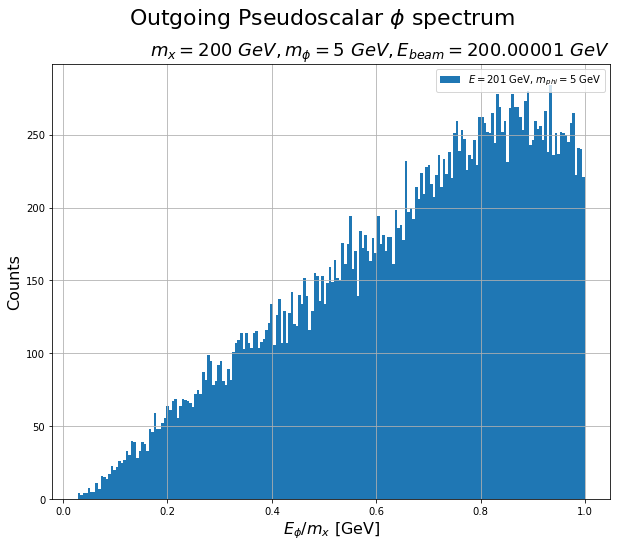

Complete


In [46]:
fig1 = plt.figure(figsize=(10,8))
# counts, bins, bars = plt.hist(energyArray, bins = nBins, density = True)
counts1, bins1, bars1 = plt.hist(energyArray1, bins = nBins, density = False, label = r'$E=201$ GeV, $m_{phi} = 5$ GeV')
# counts2, bins2, bars2 = plt.hist(energyArray2, bins = nBins, density = True, label = 'E=500', alpha = 0.5)
# counts3, bins3, bars3 = plt.hist(energyArray3, bins = nBins, density = True, label = 'E=1000', alpha = 0.5)
# counts4, bins4, bars4 = plt.hist(energyArray4, bins = nBins, density = True, label = 'E=5000', alpha = 0.5)
# counts5, bins5, bars5 = plt.hist(energyArray5, bins = nBins, density = True, label = 'E=6500', alpha = 0.5)
# counts6, bins6, bars6 = plt.hist(energyArray6, bins = nBins, density = True, label = 'R=100P',alpha = 0.75)
# counts7, bins7, bars7 = plt.hist(energyArray7, bins = nBins, density = True, label = 'R=1000P',alpha = 0.75)
# counts8, bins8, bars8 = plt.hist(energyArray8, bins = nBins, density = True, label = 'R=10000P',alpha = 0.75)


#########################################
#           Interpolation Crap

# eRange1 = np.linspace(min(energyArray1),max(energyArray1), nBins)
# interpolation1 = interpolate.interp1d(eRange1,counts1)
# eRange2 = np.linspace(min(energyArray2),max(energyArray2), nBins)
# interpolation2 = interpolate.interp1d(eRange2,counts2)
# eRange3 = np.linspace(min(energyArray3),max(energyArray3), nBins)
# interpolation3 = interpolate.interp1d(eRange3,counts3)
# eRange4 = np.linspace(min(energyArray4),max(energyArray4), nBins)
# interpolation4 = interpolate.interp1d(eRange4,counts4)
#########################################


#########################################
#            Power Spectrum

# yVect = []
# for E in eRange4:
#     yVect.append(E*interpolation4(E))
#########################################


# plt.plot(eRange1,interpolation1(eRange1), label = 'Interpolation')
# plt.plot(eRange2,interpolation2(eRange2), label = 'Interpolation')
# plt.plot(eRange3,interpolation3(eRange3), label = 'Interpolation')
# plt.plot(eRange4,interpolation4(eRange4), label = 'Interpolation')

# plt.plot(eRange,yVect,label = 'E*counts')
# plt.plot(eRange, counts3,'r.', label = 'Sample Points')
plt.suptitle(r'Outgoing Pseudoscalar $\phi$ spectrum'.format(get_key(PID,secondaryID)),size = 22)
# plt.title('nPoints = {0}, nBins = {1}, BinWidth = {2} GeV'.format(nPoints, nBins, round(binWidth,3)),loc = 'right', fontsize = '12')
# plt.title(r'\sqrt(s) = {0} TeV, (m{1}, m{2}) = ({3},{4}) GeV'.format(10,get_key(PID,primaryID),get_key(PID,secondaryID),primaryMass,sM1),\
#           loc = 'right')
plt.title(r'$m_x = 200\ GeV, m_\phi = 5\ GeV, E_{beam} = 200.00001\ GeV$',loc = 'right', size = 18)
plt.xlabel(r'$E_{\phi}/m_x$ [GeV]', size = 16)
plt.ylabel('Counts',size = 16)
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

# integrationCheck1 = integrate.quad(interpolation1, min(eRange1), max(eRange1))
# integrationCheck2 = integrate.quad(interpolation2, min(eRange2), max(eRange2))
# integrationCheck3 = integrate.quad(interpolation3, min(eRange3), max(eRange3))
# integrationCheck4 = integrate.quad(interpolation4, min(eRange4), max(eRange4))

# print ("I1:", integrationCheck1)
# print ("I2:", integrationCheck2)
# print ("I3:", integrationCheck3)
# print ("I4:", integrationCheck4)


print ('Complete')

In [47]:
figname = input('Figure Name:')
filepath = 'Plots//21.03.29//Pseudo//' + figname 
fig1.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:1PseudoSpectrum.png
Complete


### Energy Check: 'Energy column in the .lhe file"

The "Energy" column in the `.lhe` file is the bonafide $\mu = 0$ component of the $p^\mu$ 4-vector.

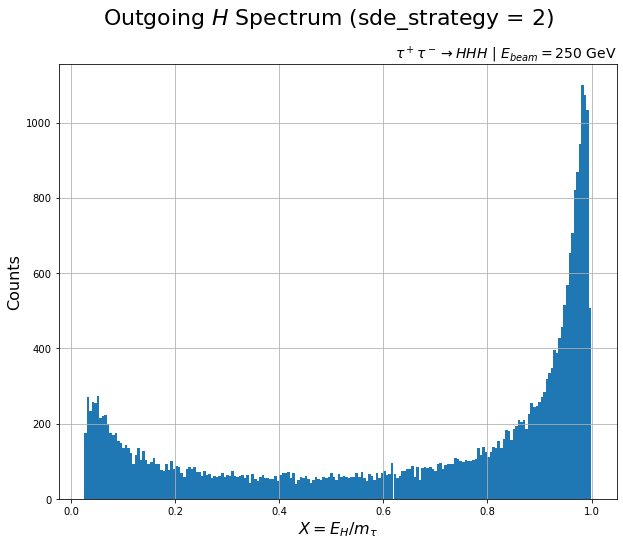

In [82]:
PM1 = float(df1[df1.PID == primaryID]['M'].unique())
SM1 = float(df1[df1.PID == secondaryID]['M'].unique())
Energy = df1[df1.PID == secondaryID]['E']/PM1
fig2 = plt.figure(figsize = (10,8))
counts1, bins1, bars1 = plt.hist(Energy, nBins, density = False)
plt.suptitle(r'Outgoing $H$ Spectrum (sde_strategy = 2)', size = 22)
plt.title(r'$\tau^+\tau^- \rightarrow HHH$ | $E_{beam} = 250$ GeV',loc = 'right', size = 14)
plt.xlabel(r'$X = E_H / m_{\tau}$', size = 16)
plt.ylabel('Counts', size = 16)
plt.grid()
plt.show()

In [13]:
figname = input('Figure Name:')
filepath = 'Plots/21.3.23/' + figname 
fig2.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:UpdatedPlot.png
Complete


### Energy Check, $E = \sqrt{(\vec{p}\cdot \vec{p} + m^2)}$

This checks the energy for all outgoing particles.

This is still okay because the x-axis is scaled by 10 to some power. This distribution shows the spread in energy from the numerics but it still agrees with the bonafide

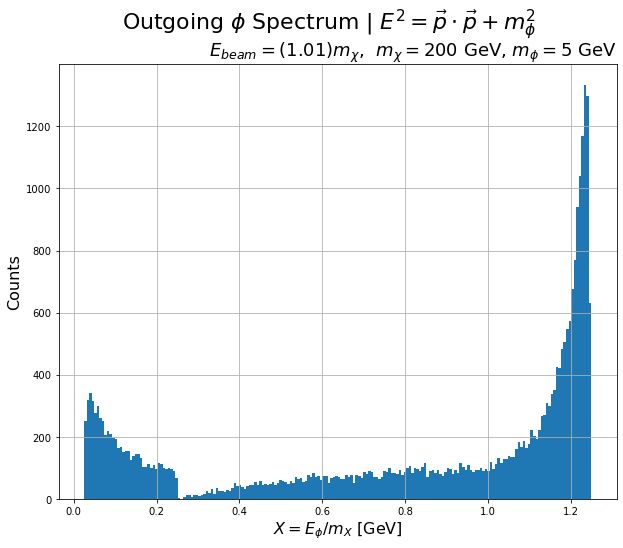

In [8]:
SM1 = float(df1[df1.PID == secondaryID]['M'].unique())
PM1 = float(df1[df1.PID == primaryID]['M'].unique())
px = df1[df1.PID == secondaryID]['Px']
py = df1[df1.PID == secondaryID]['Py']
pz = df1[df1.PID == secondaryID]['Pz']
Energy = df1[df1.PID == secondaryID]['E']

pxArray = np.asarray(px)
pyArray = np.asarray(py)
pzArray = np.asarray(pz)
EVect = []
for i in range(0,len(pxArray)):
    momentum2 = pxArray[i]**2 + pyArray[i]**2 + pzArray[i]**2
    Energy = np.sqrt(momentum2 + SM1**2)
    EVect.append(Energy/PM1)


fig3 = plt.figure(figsize = (10,8))
counts, bins, bars = plt.hist(EVect, nBins, density = False)
plt.suptitle(r'Outgoing $\phi$ Spectrum | $E^2 = \vec{p} \cdot \vec{p} + m_\phi^2$', size = 22)
plt.title(r'$E_{beam} = (1.01) m_\chi$,  $m_\chi = 200$ GeV, $m_\phi = 5$ GeV',loc = 'right', size = 18)
plt.xlabel(r'$X = E_{\phi}/m_X$ [GeV]', size = 16)
plt.ylabel('Counts', size = 16)
plt.grid()
plt.show()

In [ ]:
figname = input('Figure Name:')
filepath = 'Plots/' + figname 
fig3.savefig(filepath, dpi = 700)
print ('Complete')

### Momentum Magnitude Check

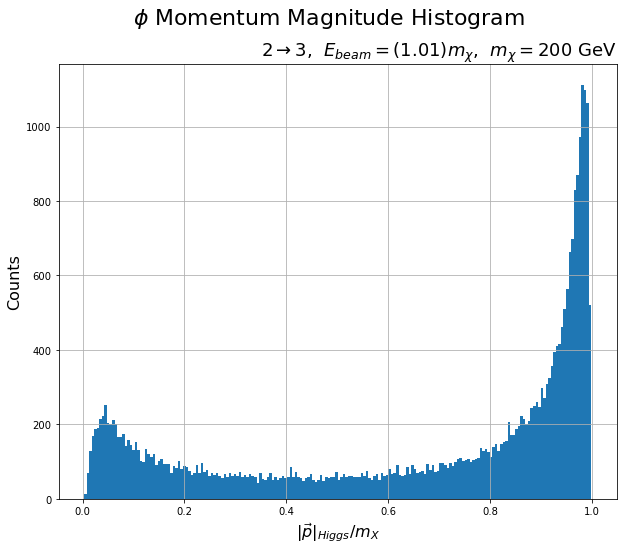

In [83]:
PM1 = float(df1[df1.PID == primaryID]['M'].unique())
SM1 = float(df1[df1.PID == secondaryID]['M'].unique())
px = df1[df1.PID == secondaryID]['Px']/PM1
py = df1[df1.PID == secondaryID]['Py']/PM1
pz = df1[df1.PID == secondaryID]['Pz']/PM1

momentum = np.sqrt(px**2 + py**2 + pz**2)
fig4 = plt.figure(figsize=(10,8))
plt.hist(momentum,nBins, density = False)
plt.suptitle(r'$\phi$ Momentum Magnitude Histogram', size = 22)
plt.title(r'$2\rightarrow3$,  $E_{beam} = (1.01) m_\chi$,  $m_\chi = 200$ GeV',loc = 'right', size = 18)
plt.xlabel(r'$|\vec{p}|_{Higgs} / m_X $', size = 16)
plt.ylabel('Counts', size = 16)
plt.grid()
plt.show()

In [136]:
figname = input('Figure Name:')
filepath = 'Plots/11.15.20/' + figname 
fig4.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:phiMomentumMagnitude.png
Complete


### Momentum Component Check

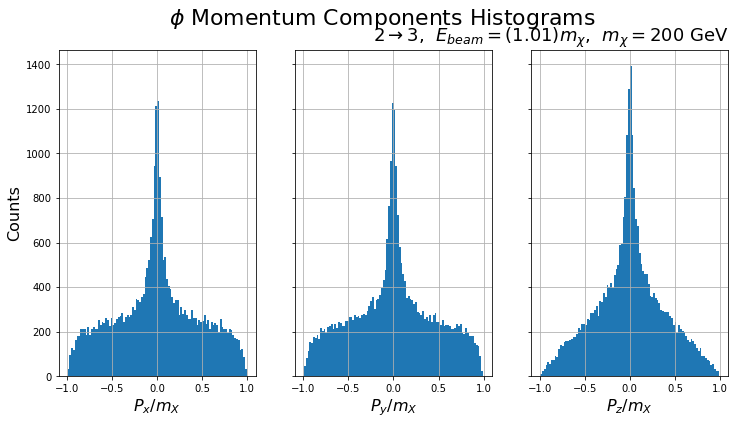

Complete


In [84]:
PM1 = float(df1[df1.PID == primaryID]['M'].unique())
SM1 = float(df1[df1.PID == secondaryID]['M'].unique())
px = df1[df1.PID == secondaryID]['Px']
py = df1[df1.PID == secondaryID]['Py']
pz = df1[df1.PID == secondaryID]['Pz']


momentum = np.sqrt(px**2 + py**2 + pz**2)
fig5, (ax1,ax2,ax3) = plt.subplots(1,3, sharey = True, figsize = (12,6))

ax1.hist(px/PM1, bins = int(nBins/2))
ax1.grid()
ax1.set_xlabel(r'$P_x/m_X$',size = 16)
ax1.set_ylabel('Counts', size = 16)

ax2.hist(py/PM1, bins = int(nBins/2))
ax2.grid()
ax2.set_xlabel(r'$P_y/m_X$',size = 16)

ax3.hist(pz/PM1, bins = int(nBins/2))
ax3.grid()
ax3.set_xlabel(r'$P_z/m_X$',size = 16)
plt.suptitle(r'$\phi$ Momentum Components Histograms', size = 22)
plt.title(r'$2\rightarrow3$,  $E_{beam} = (1.01) m_\chi$,  $m_\chi = 200$ GeV',loc = 'right', size = 18)
plt.show()


print ('Complete')

In [125]:
figname = input('Figure Name: ')
filepath = 'Plots/11.15.20/' + figname 
fig5.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name: PhiMomentumComponents.png
Complete


### $\cos\theta_{if}$ check (INCOMPLETE)

This is an incomplete check.

The initial momentum data are the scalar components of all of the incomming tau's, NOT including any of the incomming anti-taus. 10000 events, so there are 10000 entries for EACH component of the scalar momentum.

The final momentum data are all of the scalar components of all of the outgoing phi's. There are 10000 events, so there are 30000 outgoing phis. Each phi has 3 scalar momentum components. This proceedure grabs all of the the scalar components of each phi so each component has 30000 entries.

The plot data is the dot product of all of the initial momentum (10000 entries) and the first 10000 entries of the final momentum data.

For a given particle, this checks the angle between the incoming and outgoing 
For an initial (final)-state particle with 3-momentum $\vec{p_{i,(f)}}$, we have:

$$ \vec{p_i} = (0,0,P_z) \ \text{and} \ \vec{p_f} = (P'_x, P'_y, P'_z)$$ where we know all the components of these vectors.

The dot product of the three momenta is:

$$\vec{p_i} \cdot \vec{p_f} = |p_i| |p_f| \cos\theta_{if} = P_z P'_z$$
$$\cos\theta_{if} = \frac{P_z P'_z}{|p_i| |p_f|}$$

In [7]:
CosDict = {}

In [17]:
# You can read in all 4 data files simultaneously, but you have to 
# populate the data dictionary individually

# Change fileIn1 to the other files and then change  
df1 = pd.read_csv(CSVFilePath(fileIn1),sep = ',')

pxi = np.asarray(df1[df1.PID == primaryID]['Px'])
pyi = np.asarray(df1[df1.PID == primaryID]['Py'])
pzi = np.asarray(df1[df1.PID == primaryID]['Pz'])
pxf = np.asarray(df1[df1.PID == secondaryID]['Px'])
pyf = np.asarray(df1[df1.PID == secondaryID]['Py'])
pzf = np.asarray(df1[df1.PID == secondaryID]['Pz'])

CosVect = []
for j in range(0,len(pxi)):
    pxij = pxi[j]
    pyij = pyi[j]
    pzij = pzi[j]
    pxfj = pxf[j]
    pyfj = pyf[j]
    pzfj = pzf[j]
    magPij = np.sqrt(pxij**2 + pyij**2 + pzij**2)
    magPfj = np.sqrt(pxfj**2 + pyfj**2 + pzfj**2)
    
    numerator = pzij * pzfj
    denominator = magPij*magPfj
    CosVect.append(numerator/denominator)


# Update the key in CosDict for different data files.
# Each data file should correspond to a different data file.
CosDict.update( {'4': CosVect})
print ('Complete')

Complete


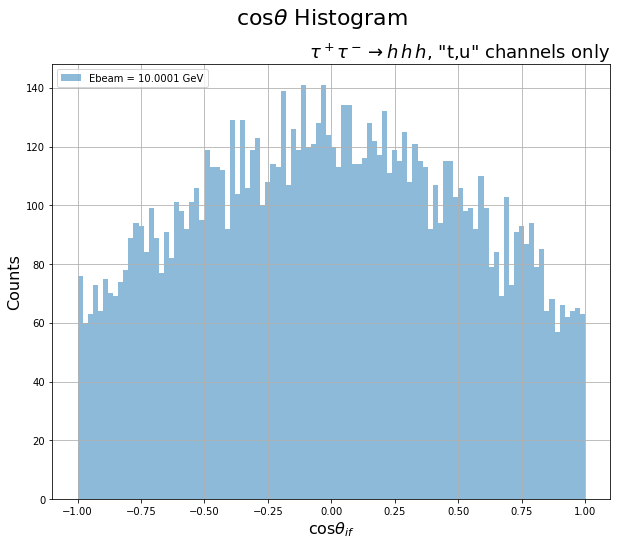

In [19]:
fig6 = plt.figure(figsize = (10,8))
# counts1, bins1, bars1 = plt.hist(CosDict['1'],bins = nBins, label = 'Ebeam = 10.1 GeV')
# counts2, bins2, bars2 = plt.hist(CosDict['2'],bins = nBins, alpha = 0.5, label = 'Ebeam = 10.01 GeV')
# counts3, bins3, bars3 = plt.hist(CosDict['3'],bins = nBins, alpha = 0.5, label = 'Ebeam = 10.001 GeV')
counts4, bins4, bars4 = plt.hist(CosDict['4'],bins = nBins, alpha = 0.5, label = 'Ebeam = 10.0001 GeV')
plt.legend(loc = 'upper left')
plt.suptitle(r'$\cos\theta$ Histogram', size = 22)
# plt.title(r'$\tau^+ \tau^- \rightarrow h h$,  t & u channels only,  $m_\tau = 10$ GeV',loc = 'right', size = 18)
plt.title(r'$\tau^+\tau^- \rightarrow h \, h \, h$, "t,u" channels only', size = 18, loc = 'right')
plt.xlabel(r'$\cos\theta_{if}$', size = 16)
plt.ylabel('Counts', size = 16)
plt.grid()

In [90]:
figname = input('Figure Name: ')
filepath = 'Plots/' + figname 
fig6.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name: e+e-2mu+mu-Theta.png
Complete


### $\cos\theta_{12}$ Check

This cell plots a histogram of angle between two $\phi$'s that we care about.
These can either be the two *most* or *least* energetic $\phi$'s.

Change the following lines:

    10: energyPrime = <min / max>(modDF2.E) 
    
The `<min / max>` determines which $\phi$ we **don't** care about. `min` means that we don't care about the $\phi$ with minimum energy and vice-versa.

In [53]:
eventNums = df1['EventNo.'].unique()
modDF1 = df1[df1.PID == secondaryID] # pick out only the outgoing Higgs'

cosThetaVect = []
energyVect = []
for j in eventNums:
    modDF2 = modDF1[modDF1['EventNo.'] == j] # grab the dataframe for event# j
    energyPrime = max(modDF2.E) # select out the minimum energy
    energyVect.append(energyPrime)
    modDF3 = modDF2.drop(modDF2[modDF2.E == energyPrime].index) # drop the row with the min energy

    # calculate angle
    p1x = modDF3.iloc[0]['Px']
    p1y = modDF3.iloc[0]['Py']
    p1z = modDF3.iloc[0]['Pz']
    p2x = modDF3.iloc[1]['Px']
    p2y = modDF3.iloc[1]['Py']
    p2z = modDF3.iloc[1]['Pz']

    numerator = (p1x*p2x + p1y*p2y + p1z*p2z)
    denominator = np.sqrt(p1x**2 + p1y**2 + p1z**2) * np.sqrt(p2x**2 + p2y**2 + p2z**2)
    cosTheta = (numerator / denominator)
    cosThetaVect.append(cosTheta)    
    
eAvg = np.mean(energyVect)
print ('eAvg: = ',eAvg)

print ('Complete')

eAvg: =  176.361473677932
Complete


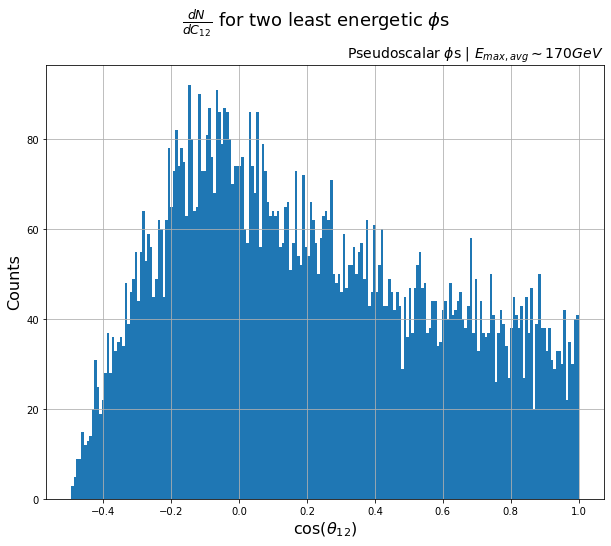

In [54]:
fig7 = plt.figure(figsize = (10,8))
plt.hist(cosThetaVect,bins = nBins)
plt.xlabel(r'$\cos(\theta_{12})$', size = 16)
plt.ylabel('Counts', size = 16)
plt.suptitle(r'$\frac{dN}{dC_{12}}$ for two least energetic $\phi$s', size = 18)
plt.title(r'Pseudoscalar $\phi$s | $E_{max, avg} \sim 170 GeV$',loc = "right", size = 14)
plt.grid()
plt.show()

In [55]:
figname = input('Figure Name:')
filepath = 'Plots//21.03.29//Pseudo//' + figname 
fig7.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:2PseudoC12LeastEnergetic.png
Complete


### $\frac{dN}{dC_{12}}$ for the 2 most energetic $\phi$s subject to cuts

In this cell, we impose an arbitrary cut of $\cos(\theta) = 0.8$

The method of gradually trimming down the big dataframe seems to work so we will continue to use that strategy and trim down the dataframe from the previous cell.

In [3]:
eventNums = df1['EventNo.'].unique()
modDF1 = df1[df1.PID == secondaryID] # pick out only the outgoing Higgs'

cosThetaVectLESS = []
cosThetaVectMORE = []
energyVect = []
for j in eventNums:
    modDF2 = modDF1[modDF1['EventNo.'] == j] # grab the dataframe for event# j
    energyPrime = min(modDF2.E) # select out the minimum energy
    energyVect.append(energyPrime)
    modDF3 = modDF2.drop(modDF2[modDF2.E == energyPrime].index) # drop the row with the min energy

    # Calculate angle
    p1x = modDF3.iloc[0]['Px']
    p1y = modDF3.iloc[0]['Py']
    p1z = modDF3.iloc[0]['Pz']
    p2x = modDF3.iloc[1]['Px']
    p2y = modDF3.iloc[1]['Py']
    p2z = modDF3.iloc[1]['Pz']

    numerator = (p1x*p2x + p1y*p2y + p1z*p2z)
    denominator = np.sqrt(p1x**2 + p1y**2 + p1z**2) * np.sqrt(p2x**2 + p2y**2 + p2z**2)
    cosTheta = (numerator / denominator)
    
    # Cuts
    if cosTheta <= -0.8: # This plots the events when C12 < -0.8
        cosThetaVectLESS.append(cosTheta)  
        
    if cosTheta >= -0.8:
        cosThetaVectMORE.append(cosTheta)

print ('Complete')

Complete


Text(0.5, 0.98, '$\\frac{dN}{dC_{12}}$ for two most energetic $\\phi$s, y-axis shared')

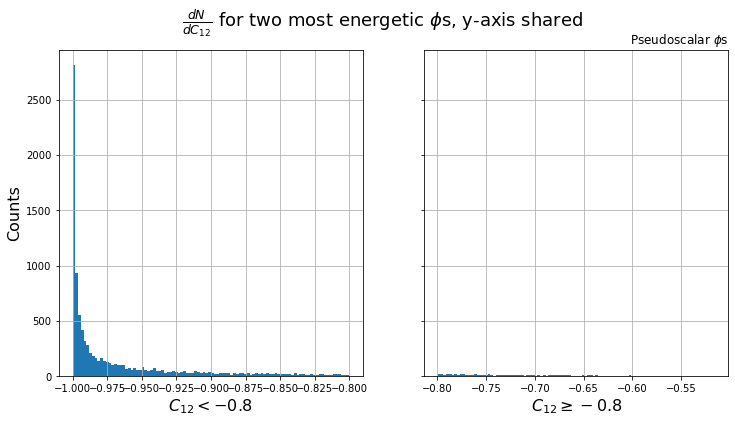

In [4]:
fig8, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (12,6))

ax1.hist(cosThetaVectLESS, bins = int(nBins/2))
ax1.grid()
ax1.set_xlabel(r'$C_{12} < -0.8$',size = 16)
ax1.set_ylabel('Counts', size = 16)

ax2.hist(cosThetaVectMORE, bins = int(nBins/2))
ax2.grid()
ax2.set_title('Pseudoscalar $\phi$s', loc = 'right')
ax2.set_xlabel(r'$C_{12} \geq -0.8$',size = 16)

fig8.suptitle(r'$\frac{dN}{dC_{12}}$ for two most energetic $\phi$s, y-axis shared', size = 18)


In [67]:
figname = input('Figure Name:')
filepath = 'Plots/12.9.20/Pseudo/' + figname 
fig8.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:P_plots3and4.png
Complete


### Spectrum for two most energetic phi's

In [59]:
eventNums = df1['EventNo.'].unique()
modDF1 = df1[df1.PID == secondaryID] # pick out only the outgoing Higgs'

cosThetaVectLESS = []
cosThetaVectMORE = []
energyVect = []

for j in eventNums:
    modDF2 = modDF1[modDF1['EventNo.'] == j] # grab the dataframe for event# j
    energyPrime = min(modDF2.E) # select out the minimum energy, this will be dropped
    modDF3 = modDF2.drop(modDF2[modDF2.E == energyPrime].index) # drop the row with the min energy

    for energy in modDF3.E:
        energyVect.append(energy/pM1)

print (energyPrime)
print ('Complete')

101.81001107
Complete


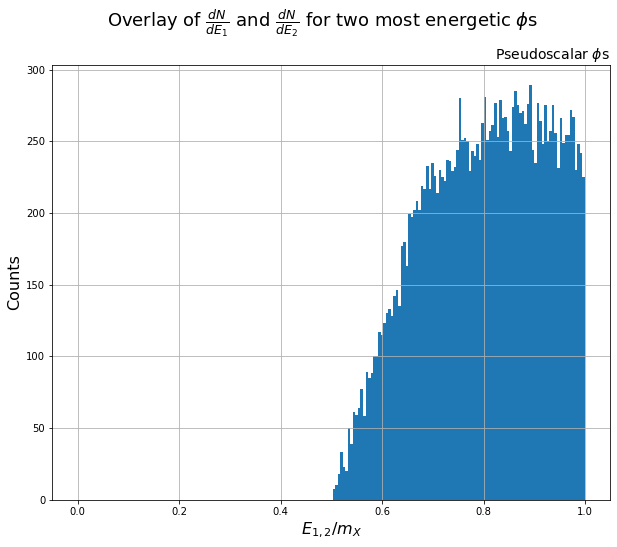

In [60]:
fig9 = plt.figure(figsize = (10,8))
plt.hist(energyVect,bins = int(nBins/2))
plt.xlabel(r'$E_{1,2}/m_X$', size = 16)
plt.ylabel('Counts', size = 16)
plt.suptitle(r'Overlay of $\frac{dN}{dE_1}$ and $\frac{dN}{dE_2}$ for two most energetic $\phi$s', size = 18)
plt.title(r'Pseudoscalar $\phi$s',loc = "right", size = 14)
plt.xlim(-0.05,1.05)
plt.grid()
plt.show()

In [61]:
figname = input('Figure Name:')
filepath = 'Plots//21.03.29//Pseudo//' + figname 
fig9.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:5PseudodNdE12High.png
Complete


### $\frac{dN}{dE_3}$ Spectrum of least energetic $\phi$

In [62]:
eventNums = df1['EventNo.'].unique()
modDF1 = df1[df1.PID == secondaryID] # pick out only the outgoing Higgs'

energyMinVect = []
for j in eventNums:
    modDF2 = modDF1[modDF1['EventNo.'] == j] # grab the dataframe for event# j
    energyPrime = min(modDF2.E) # select out the minimum energy
    energyMinVect.append(energyPrime/pM1)

print (energyPrime)
print ('Complete')

101.81001107
Complete


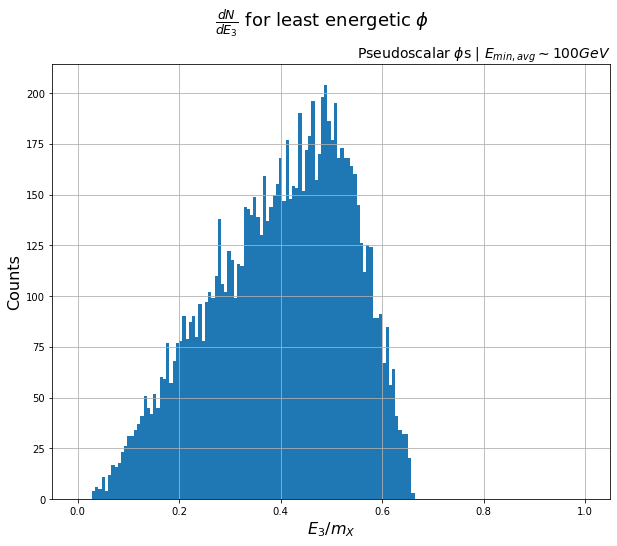

In [63]:
fig10 = plt.figure(figsize = (10,8))
plt.hist(energyMinVect,bins = int(nBins/2))
plt.xlabel(r'$E_3/m_X$', size = 16)
plt.ylabel('Counts', size = 16)
plt.suptitle(r'$\frac{dN}{dE_3}$ for least energetic $\phi$', size = 18)
plt.title(r'Pseudoscalar $\phi$s | $E_{min, avg} \sim 100 GeV$',loc = "right", size = 14)
plt.xlim(-0.05,1.05)
plt.grid()
plt.show()

In [64]:
figname = input('Figure Name:')
filepath = 'Plots//21.03.29//Pseudo//' + figname 
fig10.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:6PseudodNdE3.png
Complete


### $\frac{dN}{dE_3}$ subject to $C_{12}$ cuts

In [75]:
eventNums = df1['EventNo.'].unique()
modDF1 = df1[df1.PID == secondaryID] # pick out only the outgoing Higgs'

dE3LESS = []
dE3MORE = []
energyVect = []
for j in eventNums:
    modDF2 = modDF1[modDF1['EventNo.'] == j] # grab the dataframe for event# j
    energyPrime = min(modDF2.E) # select out the minimum energy
    energyVect.append(energyPrime)
    
    
    modDF3 = modDF2.drop(modDF2[modDF2.E == energyPrime].index) # drop the row with the min energy
    # Calculate angle
    p1x = modDF3.iloc[0]['Px']
    p1y = modDF3.iloc[0]['Py']
    p1z = modDF3.iloc[0]['Pz']
    p2x = modDF3.iloc[1]['Px']
    p2y = modDF3.iloc[1]['Py']
    p2z = modDF3.iloc[1]['Pz']

    numerator = (p1x*p2x + p1y*p2y + p1z*p2z)
    denominator = np.sqrt(p1x**2 + p1y**2 + p1z**2) * np.sqrt(p2x**2 + p2y**2 + p2z**2)
    cosTheta = (numerator / denominator)
    
    # Cuts
    if cosTheta <= -0.8: # This plots the events when C12 < -0.8
        # Grab energy of least energetic phi  
        dE3LESS.append(energyPrime/pM1)
    if cosTheta >= -0.8:
        # Grab energy of least energetic phi
        dE3MORE.append(energyPrime/pM1)

print ('Complete')

Complete


Total Length: 10000


Text(0.5, 0.98, '$\\frac{dN}{dE_3}$ for least energetic $\\phi$, y-axis shared')

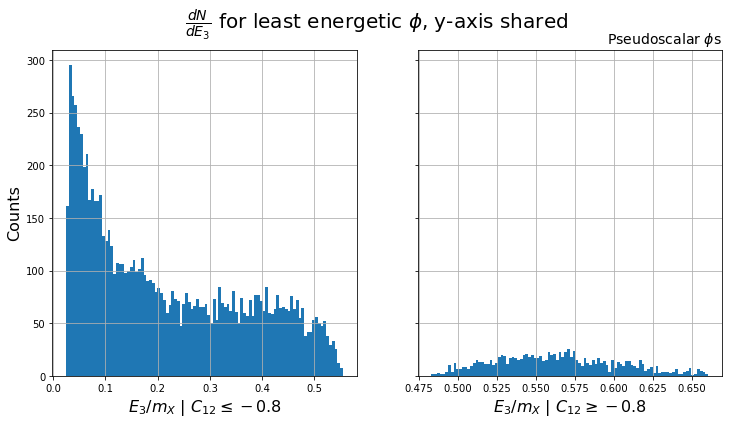

In [77]:
print ('Total Length:',(len(dE3LESS) + len(dE3MORE)))

fig11, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (12,6))

ax1.hist(dE3LESS, bins = int(nBins/2))
ax1.grid()
ax1.set_xlabel(r'$E_3/m_X \ | \ C_{12} \leq -0.8$',size = 16)
ax1.set_ylabel('Counts', size = 16)
# ax1.set_title(r'Cut: $C_{12}\leq-0.8$', loc = 'left')

ax2.hist(dE3MORE, bins = int(nBins/2))
ax2.grid()
ax2.set_xlabel(r'$E_3/m_X \ | \ C_{12} \geq -0.8$',size = 16)
ax2.set_title(r'Pseudoscalar $\phi$s',loc = 'right', size = 14)

fig11.suptitle(r'$\frac{dN}{dE_3}$ for least energetic $\phi$, y-axis shared', size = 20)

In [78]:
figname = input('Figure Name:')
filepath = 'Plots/12.9.20/Pseudo/' + figname 
fig11.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:P_Plots4and5.png
Complete


### $\frac{dN}{dE_1}$ for Most energetic $\phi$ subject to $C_{12}$ cuts

In [44]:
eventNums = df1['EventNo.'].unique()
modDF1 = df1[df1.PID == secondaryID] # pick out only the outgoing Higgs'

dE1LESS = []
dE1MORE = []
energyVect = []
for j in eventNums:
    modDF2 = modDF1[modDF1['EventNo.'] == j] # grab the dataframe for event# j
    energyPrime = max(modDF2.E) # select out the maximum energy
    energyCut = min(modDF2.E)
    energyVect.append(energyPrime)
    modDF3 = modDF2.drop(modDF2[modDF2.E == energyCut].index) # drop the row with the min energy

    # Calculate angle
    p1x = modDF2.iloc[0]['Px']
    p1y = modDF2.iloc[0]['Py']
    p1z = modDF2.iloc[0]['Pz']
    p2x = modDF2.iloc[1]['Px']
    p2y = modDF2.iloc[1]['Py']
    p2z = modDF2.iloc[1]['Pz']

    numerator = (p1x*p2x + p1y*p2y + p1z*p2z)
    denominator = np.sqrt(p1x**2 + p1y**2 + p1z**2) * np.sqrt(p2x**2 + p2y**2 + p2z**2)
    cosTheta = (numerator / denominator)
    
    # Cuts
    if cosTheta <= -0.8: # This plots the events when C12 < -0.8
        # Grab energy of least energetic phi  
        dE1LESS.append(energyPrime/pM1)
    if cosTheta >= -0.8:
        # Grab energy of least energetic phi
        dE1MORE.append(energyPrime/pM1)

print ('Complete')

Complete


Total Length: 10000


Text(0.5, 0.98, '$\\frac{dN}{dE_1}$ for most energetic $\\phi$, y-axis shared')

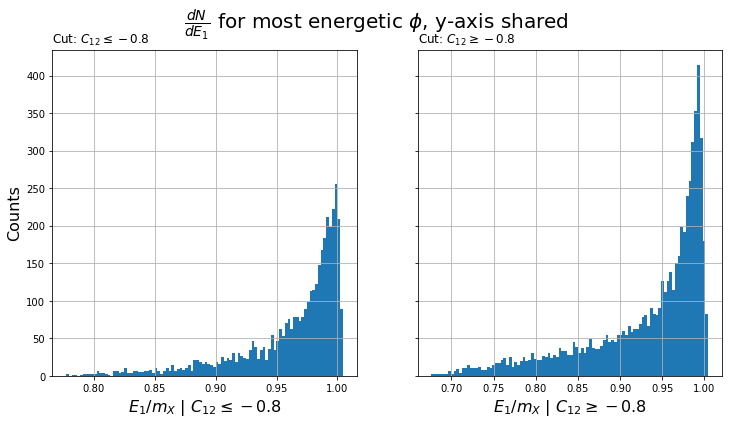

In [46]:
print ('Total Length:',(len(dE1LESS) + len(dE1MORE)))

fig12, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (12,6))

ax1.hist(dE1LESS, bins = int(nBins/2))
ax1.grid()
ax1.set_xlabel(r'$E_1/m_X \ | \ C_{12} \leq -0.8$',size = 16)
ax1.set_ylabel('Counts', size = 16)
ax1.set_title(r'Cut: $C_{12}\leq-0.8$', loc = 'left')

ax2.hist(dE1MORE, bins = int(nBins/2))
ax2.grid()
ax2.set_xlabel(r'$E_1/m_X \ | \ C_{12} \geq -0.8$',size = 16)
ax2.set_title(r'Cut: $C_{12}\geq-0.8$',loc = 'left')

fig12.suptitle(r'$\frac{dN}{dE_1}$ for most energetic $\phi$, y-axis shared', size = 20)

In [47]:
figname = input('Figure Name:')
filepath = 'Plots/11.17.20/200.2/' + figname 
fig12.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:dNdE1.png
Complete


### Dalitz Plots

In this section we want to generate Dalitz Plots for the simulated events.

Note: For very slow dark matter colliding colinearly, we can take the initial state to be a single bound state of mass $M=2m_x$ with zero 3-momentum
For a three-body decay, with the following 4 vectors:

$P^\mu = (2m_x,\vec{0})\\
P_a = (E_a,\vec{P_a})\\
P_b = (E_b,\vec{P_b})\\
P_c = (E_c,\vec{P_c})$

we have as our Daliz plot axes $m_{i,j}^2$ defined by:

$$ m_{ij} \equiv (P_i + P_j)^2 $$
(I will name these "Dalitz Parameters")

constrained by:

$$ M^2 + m_{12}^2 + m_{23}^2 + m_{31}^2 =\text{constant} $$

I am going to take the following subscript convention for Pythonic stuff:

- $\phi_1 \equiv$ the highest energy phi

- $\phi_3 \equiv$ the lowest energy phi
 
We will be plotting:

- $m_{23} = $ RHS with highest energy phi stuff
- $m_{12} = $ RHS with lowest energy phi stuff

This seems easiest to do with the lowest and highest energy phi's in each event so lets proceed with those.

In [3]:
date = '21.3.25\\Pseudo\\'
# fileIn1 = date+input("Filename: ")
fileIn1 = date+'PseudoR27.csv'
df1 = pd.read_csv(CSVFilePath(fileIn1),sep = ',')
primaryID = PID['chi']
secondaryID = PID['phi']
nBins = 200
sM1 = float(df1[df1.PID == secondaryID]['M'].unique())
pM1 = float(df1[df1.PID == primaryID]['M'].unique())

print ('Complete')

Complete


In [4]:
primaryMass   = pM1
secondaryMass = sM1

eventNums = df1['EventNo.'].unique()
m12Vect = []
m23Vect = []
negativeTracking = []
for j in eventNums:
    modDF1 = df1[df1['EventNo.'] == j] # grab the dataframe for event# j

    # grab all Primary info
    primaryE  = modDF1[modDF1.PID == primaryID].iloc[0]['E']
    primaryM  = 2*modDF1[modDF1.PID == primaryID].iloc[0]['M']
    primaryPx,primaryPy,primaryPz = 0,0,0

    # Reduce to outgoing phi's
    outgoingDF = modDF1[modDF1.PID == secondaryID] # pick out only the outgoing Higgs'

    secondaryE1  = outgoingDF.iloc[0]['E']
    secondaryP1x = outgoingDF.iloc[0]['Px']
    secondaryP1y = outgoingDF.iloc[0]['Py']
    secondaryP1z = outgoingDF.iloc[0]['Pz']


    secondaryE2  = outgoingDF.iloc[1]['E']
    secondaryP2x = outgoingDF.iloc[1]['Px']
    secondaryP2y = outgoingDF.iloc[1]['Py']
    secondaryP2z = outgoingDF.iloc[1]['Pz']


    secondaryE3  = outgoingDF.iloc[2]['E']
    secondaryP3x = outgoingDF.iloc[2]['Px']
    secondaryP3y = outgoingDF.iloc[2]['Py']
    secondaryP3z = outgoingDF.iloc[2]['Pz']

    dotProduct12 = secondaryP1x*secondaryP2x + secondaryP1y*secondaryP2y + secondaryP1z*secondaryP2z
    dotProduct23 = secondaryP2x*secondaryP3x + secondaryP2y*secondaryP3y + secondaryP2z*secondaryP3z

    m12 = sM1**2 + sM1**2 + 2*(secondaryE1*secondaryE2 - (dotProduct12))
    m23 = sM1**2 + sM1**2 + 2*(secondaryE2*secondaryE3 - (dotProduct23))

    m23Vect.append(m23)
    m12Vect.append(m12)

print ('Complete')

Complete


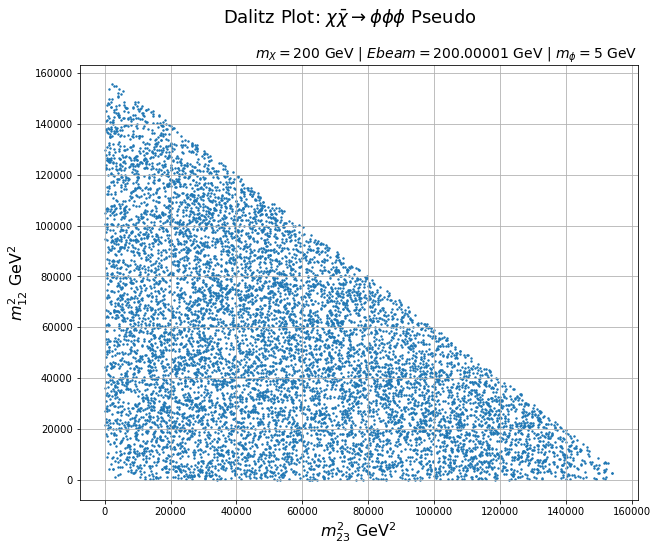

In [78]:
fig13 = plt.figure(figsize = (10,8))
plt.scatter(m23Vect,m12Vect, s = 2)
plt.xlabel(r'$m_{23}^2$ GeV$^2$', size = 16)
plt.ylabel(r'$m_{12}^2$ GeV$^2$', size = 16)
plt.suptitle(r'Dalitz Plot: $\chi \bar{\chi} \rightarrow \phi \phi \phi$ Pseudo', size = 18)
plt.title(r'$m_X = 200$ GeV | $Ebeam = 200.00001$ GeV | $m_\phi = 5$ GeV',loc = "right", size = 14)
plt.grid()
plt.show()

In [79]:
figname = input('Figure Name:')
filepath = 'Plots/21.3.29/Pseudo/' + figname 
fig13.savefig(filepath, dpi = 700)
print ('Complete')

Figure Name:PseudoE200_00001.png
Complete
